#**TP kNN & kMeans - Gorse & Monbroussou**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist 
import pandas as pd
from sklearn.model_selection import KFold

#**k-NN algorithm for classification**


We start by generating the data as explain in the TP :

In [ ]:
N=300

def Generate_data(sigma2, N=300):  
    data=np.zeros((N,2))
    label=np.zeros(N)
    for i in range(int(N/3)):
          data[i][0], data[i][1] = np.random.normal([-1,0],np.sqrt(sigma2),2)
          label[i] = 0
    for i in range(int(N/3),int(2*N/3)):
          data[i][0], data[i][1] = np.random.normal([1,0],np.sqrt(sigma2),2)
          label[i]=1
    for i in range(int(2*N/3),N):
          data[i][0], data[i][1] = np.random.normal([0,1],np.sqrt(sigma2),2)
          label[i] = 2
    return (data,label)


data,label = Generate_data(0.10)

def splitdata(data,label):
  C = list(zip(data,label))
  random.shuffle(C)
  shuffle_data, shuffle_label = zip(*C)
  data_train, label_train = np.array(shuffle_data)[:int(N*0.75)], np.array(shuffle_label)[:int(N*0.75)]
  data_test, label_test = np.array(shuffle_data)[int(0.75*N):], np.array(shuffle_label)[int(N*0.75):]
  return(data_train,label_train,data_test,label_test)



 


Then, we create the function kNN which takes the neirest neighbours and count the label of them. 

In [ ]:
def KNN(point, data, label,k):
  closest_neighbours = []
  for j,sj in enumerate(data):
    dij = np.sqrt((point[0] - sj[0])**2 + (point[1] - sj[1])**2)
    if (len(closest_neighbours) < k):
      closest_neighbours.append((label[j],dij))
    elif (dij < closest_neighbours[-1][1]):
        closest_neighbours.pop()
        closest_neighbours.append([label[j],dij])
    closest_neighbours.sort(key=lambda tup: tup[1])
  label_occ = [0,0,0]
  for element in closest_neighbours:
    label_occ[int(element[0])] += 1
  label_result = label_occ.index(max(label_occ))
  return(label_result)    


In this part we want to guess the index of a point using the knn method. The test point avec a black circle around them :

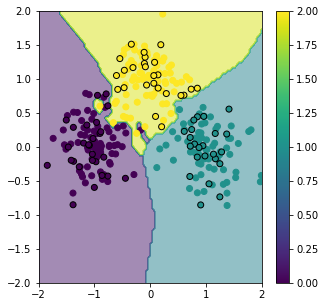

In [ ]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2,2,100)
xv, yv = np.meshgrid(x, y)

Z = np.zeros((np.shape(xv)[0], np.shape(xv)[0]))
k = 1

data_train,label_train,data_test,label_test=splitdata(Generate_data(0.1)[0],Generate_data(0.1)[1])
estimated_label=np.zeros(label_test.shape)

for ix,x in enumerate(xv[0]):
  for iy, y in enumerate(xv[0]):
    Z[ix][iy] = KNN([x,y], data_train, label_train, k)

for ix,x in enumerate(data_test):
    estimated_label[ix] = KNN([x[0],x[1]], data_train, label_train, k)

zt = np.transpose(Z)
plt.figure(figsize = (5, 5)) 
plt.contourf(xv[0],xv[0],zt,alpha=0.5)
plt.scatter(data_train[:,0],data_train[:,1],c=label_train)
plt.scatter(data_test[:,0],data_test[:,1],c=estimated_label,edgecolor="black")
plt.colorbar()

plt.show()

Here, we fixed $k=1$ and $\sigma^2 = 0,1$ but we see that the decision boundary is becomming "more precise" when we increase k. In fact, the more you increase k the more the border depends on the group and less on some isolated points.

We compute the averrage error in function of $\sigma^2$:


[0.027200000000000005, 0.07093333333333335, 0.11546666666666666, 0.1602666666666667] [0.021058226157226276, 0.03175174535885127, 0.047395368841842776, 0.05964561080992372]


Text(0, 0.5, 'Error')

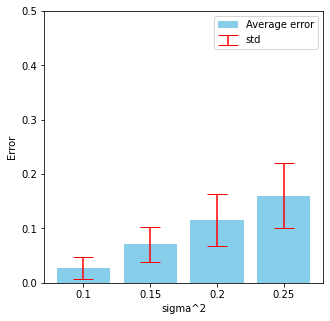

In [ ]:
k = 1
x = np.linspace(-2, 2, 100)
y = np.linspace(-2,2,100)
xv, yv = np.meshgrid(x, y)
Z = np.zeros((np.shape(xv)[0], np.shape(xv)[0]))
estimated_label=np.zeros(label_test.shape)

def error(test,estimated):
  sumerr=0
  for i in range (test.shape[0]):
    if (test[i] !=  estimated [i]):
      sumerr += 1/test.shape[0]
  return (sumerr)

recaperror=[]
def averageerror(sigma):
  sumerror=0
  for i in range (50):
    data_train,label_train,data_test,label_test=splitdata(Generate_data(sigma)[0],Generate_data(sigma)[1])
    for ix,x in enumerate(data_test):
        estimated_label[ix] = KNN([x[0],x[1]], data_train, label_train, k)
    recaperror.append(error(label_test,estimated_label))
    sumerror+=error(label_test,estimated_label)
  std=np.std(recaperror)
  return(sumerror/50,std)

sigma=[0.1,0.15, 0.20, 0.25]
resultaverageerror=[]
resultstd=[]
for i in sigma:
  resultaverageerror.append(averageerror(i)[0])
  resultstd.append(averageerror(i)[1])

print(resultaverageerror,resultstd)

plt.figure(figsize = (5,5)) 
plt.bar([str(p) for p in sigma], resultaverageerror, color = 'skyblue', label='Average error')
plt.errorbar([str(p) for p in sigma], resultaverageerror, yerr = resultstd, fmt = 'none', capsize = 10, ecolor = 'red', zorder = 2, label='std')
plt.legend()
plt.ylim(0,0.5)
plt.xlabel("sigma^2")
plt.ylabel("Error")
 


Logically enough, the error increases as the variance increases. Indeed, this is intuitive since if the variance is large, there is a greater chance that points will be "lost" in another group. However, the error (and the std) is still quite good even for a rather high variance!




#**k-Means for clustering**

We generate the new data without label to apply an unsupervised learning:

In [ ]:
def Generate_data2(sigma2, N=300):  
    data=np.zeros((N,2))
    for i in range(int(N/3)):
          data[i][0], data[i][1] = np.random.normal([-1,0],np.sqrt(sigma2),2)
    for i in range(int(N/3),int(2*N/3)):
          data[i][0], data[i][1] = np.random.normal([1,0],np.sqrt(sigma2),2)
    for i in range(int(2*N/3),N):
          data[i][0], data[i][1] = np.random.normal([0,1],np.sqrt(sigma2),2)
    return (data)

Then, we define the function Kmeans which will generate k centroids and make them move to define  k groups inside the data.

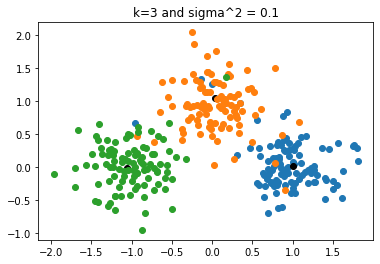

<Figure size 360x360 with 0 Axes>

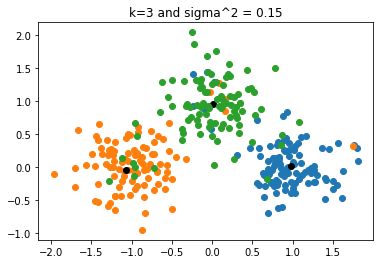

<Figure size 360x360 with 0 Axes>

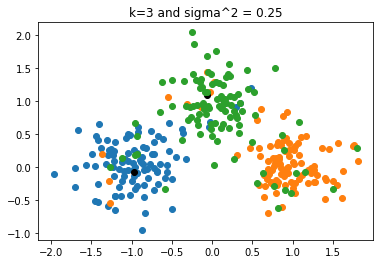

<Figure size 360x360 with 0 Axes>

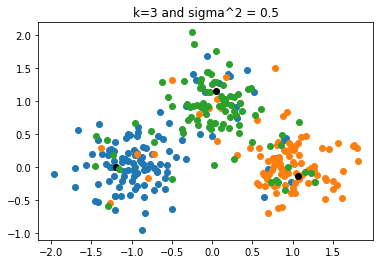

<Figure size 360x360 with 0 Axes>

In [ ]:
def Kmeans(data, k, T=1000):
    al1,al2,al3=np.random.choice(300,3,replace=False)
    centroids = (data[al1],data[al2],data[al3])
    distances = cdist(data, centroids ,'euclidean')
    points = np.array([np.argmin(i) for i in distances])
    for _ in range(T): 
          centroids = []
          for idx in range(k):
            temp_cent = data[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
          distances = cdist(data, centroids ,'euclidean')
          points = np.array([np.argmin(i) for i in distances])
    return(points,centroids)


label = Kmeans(Generate_data(0.1)[0],3)[0]
centroids =Kmeans(Generate_data(0.1)[0],3)[1] 
nb_labels = np.unique(label)
for i in nb_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
    plt.scatter(centroids[i][0],centroids[i][1],c='black')
plt.title("k=3 and sigma^2 = 0.1")
plt.figure(figsize = (5, 5))
plt.show()
 

label = Kmeans(Generate_data(0.15)[0],3)[0]
centroids = Kmeans(Generate_data(0.15)[0],3)[1]
nb_labels = np.unique(label)
for i in nb_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
    plt.scatter(centroids[i][0],centroids[i][1],c='black')
plt.title("k=3 and sigma^2 = 0.15")
plt.figure(figsize = (5, 5))
plt.show()


label = Kmeans(Generate_data(0.25)[0],3)[0]
centroids = Kmeans(Generate_data(0.25)[0],3)[1]
nb_labels = np.unique(label)
for i in nb_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
    plt.scatter(centroids[i][0],centroids[i][1],c='black')
plt.title("k=3 and sigma^2 = 0.25")
plt.figure(figsize = (5, 5))
plt.show()


label = Kmeans(Generate_data(0.5)[0],3)[0]
centroids = Kmeans(Generate_data(0.5)[0],3)[1]
nb_labels = np.unique(label)
for i in nb_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
    plt.scatter(centroids[i][0],centroids[i][1],c='black')
plt.title("k=3 and sigma^2 = 0.5")
plt.figure(figsize = (5, 5))
plt.show()
 


It can be seen that the lower the sigma, the more precise the segmentation, which is quite logical. Moreover the algorithm does not converge for k>3 and does not work well for k=1,2 which is also logical considering the data. Finally we can see that the centroids are very close to the points (-1,0),(0,1) and (1,0) which were used to generate the data, which reassures us about the efficiency of the algorithm. 

#**k-NN regression: Szeged-weather data-set**

We start by cleaning the data as asked in the TP and plot the figure according to the 3 parameters we want to study :

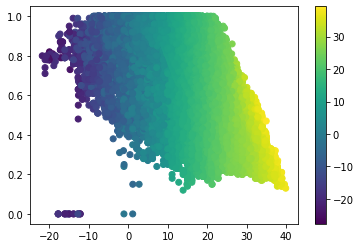

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature (C)           2000 non-null   float64
 1   Apparent Temperature (C)  2000 non-null   float64
 2   Humidity                  2000 non-null   float64
dtypes: float64(3)
memory usage: 47.0 KB


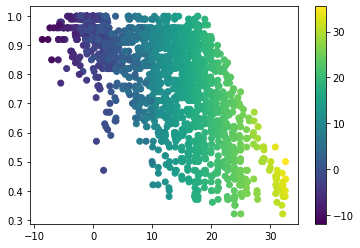

In [ ]:
weather = pd.read_csv("weatherHistory.csv")
plt.scatter(weather['Temperature (C)'],weather['Humidity'],c=weather['Apparent Temperature (C)'])
plt.colorbar()
plt.show()

weather=weather.drop(['Formatted Date','Summary','Precip Type','Wind Speed (km/h)','Wind Bearing (degrees)','Visibility (km)','Loud Cover','Pressure (millibars)','Daily Summary'],axis=1)
weather=weather[:2000]
np.random.shuffle(weather.values)
weather.info()
weather.head()

plt.scatter(weather['Temperature (C)'],weather['Humidity'],c=weather['Apparent Temperature (C)'])
plt.colorbar()
plt.show()

We modify our previous KNN function to return an estimate of the App Temperature and no a label : Then we compute the MSE and the std between our estimation and the real value for some k :

[1.292286512345679, 0.8894068707133058, 0.8588875722222223, 0.8511204900478709, 0.8380637575617284, 0.8656550361454048] [0.16437534927138997, 0.13685524340355648, 0.11067978111261449, 0.11399920006876929, 0.0989338998141262, 0.1054333092283528]


Text(0, 0.5, 'Error')

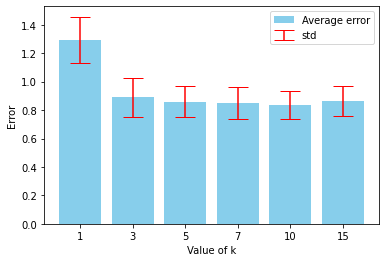

In [ ]:
def KNNestimation(point, data, label,k):
  closest_neighbours = []
  for j in range(len(data[0])):
    dij = np.sqrt((point[0] - data[0][j])**2 + (point[1] - data[1][j])**2)
    if (len(closest_neighbours) < k):
      closest_neighbours.append((label[j],dij))
    elif (dij < closest_neighbours[-1][1]):
        closest_neighbours.pop()
        closest_neighbours.append([label[j],dij])
    closest_neighbours.sort(key=lambda tup: tup[1])
  label_occ = 0
  for element in closest_neighbours:
    label_occ += element[0]/k
  return(label_occ)   


valuesk=[1,3,5,7,10,15]

total_error_average=[]
total_std_error=[]

for k in valuesk:
    weather = np.asarray(weather,dtype=np.float64)
    k_fold = KFold(n_splits=5)
    estimated_all_folds = []
    error_all_folds = []
    for train_size,test_size in k_fold.split(weather):
        xtrain , xtest = weather[train_size] , weather[test_size]
        coord1=(xtest[:,0],xtest[:,2])
        coord2=(xtrain[:,0],xtrain[:,2])
        label2=xtrain[:,1]
        estimated_apptemperature=np.zeros(xtest.shape[0])
        for ix,x in enumerate(coord1[0]):
            y=(coord1[1][ix])
            estimated_apptemperature[ix] = KNNestimation([x,y],coord2,label2, k)
        estimated_all_folds.append(estimated_apptemperature)
        error_all_folds.append(np.mean((estimated_apptemperature - xtest[:,1])**2))
    error_average = np.mean(error_all_folds)
    std_error = np.std(error_all_folds)
    total_error_average.append(error_average)
    total_std_error.append(std_error)
print(total_error_average,total_std_error)


plt.bar([str(k) for k in valuesk], total_error_average, color = 'skyblue', label='Average error')
plt.errorbar([str(k) for k in valuesk], total_error_average, yerr = total_std_error, fmt = 'none', capsize = 10, ecolor = 'red', zorder = 2, label='std')
plt.legend()
plt.xlabel("Value of k")
plt.ylabel("Error")



It can be seen that the MSE is quite low, which is a good sign. In fact, by using the average resulting from the cross validation, we can maintain a fairly high number of data trains. By having a large number of data it is quite normal to think that we will have points close to the one to be estimated and therefore that its App Temp will also be close to the points we already know. We remark also that the error decrease when k increase thanks to averaging phenomenon that avoids large errors on points to be estimated that might be a bit isolated.